# Einops Implmentation:
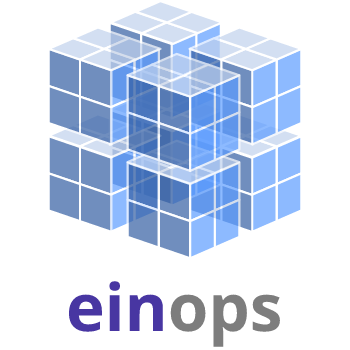


###About implementation:
The implementation can be broken down into below steps:
- **Parses patterns:** This part of the implementation splits and parses the input/output pattern into structured axis groups, handling ellipses and grouped dimensions.

- **Resolves axis sizes:** This part of the implementation matches tensor shape to pattern, infers unknown sizes, and expands ellipses if needed.

- **Expands input shape:** This part of the implementation reshapes tensor to split grouped axes into individual dimensions.

- **Handles new axes:** This part of the implementation inserts and repeats axes that are present only in the output pattern.

- **Reorders and reshapes:** This part of the implementation transposes tensor to match output axis order and reshapes into final form.


**This is the Einops implementation that supports operations like:**
- Reshaping
- Transposition
- Splitting of axes
- Merging of axes
- Repeating of axes

**The implementation works with NumPy arrays**

In [348]:
# Importing the required Libraries
import numpy as np
import math
import keyword
import warnings
from typing import List, Union, Optional, Set, Dict
import pytest

### `EinopsError` Class:
`EinopsError` is a custom exception class used to raise clear, descriptive errors when an invalid pattern or operation occurs in the rearrange logic.

In [349]:
# Error Handling Class
class EinopsError(Exception):
    pass

### `AnonymousAxis` Class:
- It represents unnamed axes defined by a positive integer (Example: 2 in a pattern)
- It is used for splitting or expanding dimensions without giving them a name.

In [350]:
# Unicode for the Ellipsis
_ELLIPSIS = "…"

# Class for unnamed axes
class AnonymousAxis:
    def __init__(self, value: str):
        self.value = int(value)
        if self.value <= 1:
            raise EinopsError("Anonymous axis must be > 1")

    def __repr__(self):
        return f"{self.value}-axis"

    def __eq__(self, other):
        return self is other

    def __hash__(self):
        return id(self)

### `ParsedExpression` Class:
- It parses a rearrangement pattern string (like 'b (h w) -> b h w') into a structured format.
- It validates axis names, grouping, and handling ellipsis.

In [351]:
# Class to Parse Expression
class ParsedExpression:
    # Initialization Function
    def __init__(self, expression: str, allow_underscore: bool = False, allow_duplicates: bool = False):
        self.composition: List[Union[str, List[Union[str, AnonymousAxis, int]]]] = []
        self.identifiers: Set[str] = set()
        self.has_ellipsis = "..." in expression
        self.has_ellipsis_parenthesized: Optional[bool] = None

        if self.has_ellipsis:
            if expression.count("...") != 1 or expression.count(".") != 3:
                raise EinopsError("Only one ellipsis (...) is allowed in the expression")
            expression = expression.replace("...", _ELLIPSIS)

        bracket_group: Optional[List[Union[str, AnonymousAxis, int]]] = None
        current_token = ""

        # Storing and processing of tokens
        def flush_token():
            nonlocal current_token, bracket_group
            if not current_token:
                return
            token = current_token.strip()
            current_token = ""

            if token == _ELLIPSIS:
                if bracket_group is not None:
                    raise EinopsError("Ellipsis cannot appear inside parentheses")
                self.composition.append(_ELLIPSIS)
                self.has_ellipsis_parenthesized = False
                return

            if token.isdigit():
                value = int(token)
                if value == 1:
                    if bracket_group is None:
                        self.composition.append([])
                        return
                    else:
                        axis = 1
                else:
                    axis = AnonymousAxis(token)
            else:
                if not ParsedExpression._is_valid_axis_name(token, allow_underscore):
                    raise EinopsError(f"Invalid axis identifier: '{token}'")
                axis = token

            if isinstance(axis, str):
                if axis in self.identifiers and not allow_duplicates and not (allow_underscore and axis == "_"):
                    raise EinopsError(f"Duplicate axis name '{axis}' in pattern")
                self.identifiers.add(axis)

            if bracket_group is None:
                self.composition.append([axis])
            else:
                bracket_group.append(axis)

        for char in expression:
            if char == "(":
                if bracket_group is not None:
                    raise EinopsError("Nested parentheses are not allowed")
                flush_token()
                bracket_group = []
            elif char == ")":
                flush_token()
                if bracket_group is None:
                    raise EinopsError("Unmatched closing parenthesis")
                self.composition.append(bracket_group)
                bracket_group = None
            elif char.isspace():
                flush_token()
            else:
                current_token += char

        flush_token()
        if bracket_group is not None:
            raise EinopsError("Unclosed parenthesis in expression")

    def flat_axes(self) -> List[Union[str, AnonymousAxis, int]]:
        flat = []
        for entry in self.composition:
            if isinstance(entry, list):
                flat.extend(entry)
            elif isinstance(entry, str):
                flat.append(entry)
        return flat

    @staticmethod
    def _is_valid_axis_name(name: str, allow_underscore: bool = False) -> bool:
        if not name.isidentifier():
            return False
        if name[0] == "_" or name[-1] == "_":
            return name == "_" and allow_underscore
        if keyword.iskeyword(name):
            warnings.warn(f"'{name}' is a Python keyword. Discouraged as axis name.", RuntimeWarning)
        if name == "axis":
            warnings.warn("'axis' is discouraged as an axis name.", FutureWarning)
        return True

## `resolve_axes_lengths` Function:
- It determines the size of each axis in the pattern by matching the parsed input pattern to the tensor's actual shape
- It handles ellipses, grouped axes, and inferred dimensions.

In [352]:
# function for determining the size of each axis and handles ellipses, grouped axes,  etc.
def resolve_axes_lengths(
    tensor: np.ndarray,
    parsed: ParsedExpression,
    axes_lengths: Dict[str, int]
) -> Dict[str, int]:
    shape = list(tensor.shape)
    resolved: Dict[str, int] = dict(axes_lengths)
    composition = parsed.composition.copy()

    # Handle ellipsis in input
    if parsed.has_ellipsis:
        flat = parsed.flat_axes()
        ellipsis_index = flat.index(_ELLIPSIS)
        num_ellipsis_dims = len(shape) - (len(flat) - 1)
        if num_ellipsis_dims < 0:
            raise EinopsError("Ellipsis cannot match negative number of dimensions")
        actual_ellipsis = shape[ellipsis_index : ellipsis_index + num_ellipsis_dims]
        for i, size in enumerate(actual_ellipsis):
            resolved[f"__ellipsis_{i}"] = size

        actual_ellipsis_axes = [f"__ellipsis_{i}" for i in range(num_ellipsis_dims)]
        new_composition = []
        for entry in composition:
            if entry == _ELLIPSIS:
                for ax in actual_ellipsis_axes:
                    new_composition.append([ax])
            else:
                new_composition.append(entry)
        composition = new_composition
    else:
        # When grouping is present, strict dimension equality is not required.
        grouped_axis_found = any(
            isinstance(e, list) and len(e) >= 2
            for e in composition
        )
        if not grouped_axis_found:
            expected_tensor_dims = len([entry for entry in composition])
            if expected_tensor_dims != len(shape):
                raise EinopsError(
                    f"Expected {expected_tensor_dims} tensor dimensions, got {len(shape)}"
                )

    total_entries = len(composition)
    shape_index = 0
    for i, entry in enumerate(composition):
        # If not the last pattern entry, always consume exactly one tensor dimension.
        if i < total_entries - 1:
            current_dim = shape[shape_index]
            shape_index += 1
        else:
            remaining = shape[shape_index:]
            if isinstance(entry, list) and len(remaining) == len(entry):
                for j, axis in enumerate(entry):
                    current_dim = remaining[j]
                    if isinstance(axis, str):
                        if axis in resolved:
                            if resolved[axis] != current_dim:
                                raise EinopsError(
                                    f"Axis '{axis}' has conflicting size: {resolved[axis]} vs {current_dim}"
                                )
                        else:
                            resolved[axis] = current_dim
                    elif isinstance(axis, AnonymousAxis):
                        pass
                    elif isinstance(axis, int):
                        if axis != current_dim:
                            raise EinopsError(
                                f"Grouped axis mismatch: expected {axis}, got {current_dim}"
                            )
                shape_index = len(shape)
                continue
            else:
                current_dim = math.prod(remaining)
                shape_index = len(shape)

        # Process the entry
        if isinstance(entry, list):
            # For a grouped axis
            known_sizes = []
            for a in entry:
                if isinstance(a, str) and a in resolved:
                    known_sizes.append(resolved[a])
                elif isinstance(a, AnonymousAxis):
                    known_sizes.append(a.value)
                elif isinstance(a, int):
                    known_sizes.append(a)
                else:
                    known_sizes.append(None)

            unknown_indices = [j for j, v in enumerate(known_sizes) if v is None]

            if not unknown_indices:
                product_val = 1
                for sz in known_sizes:
                    product_val *= sz
                if product_val != current_dim:
                    raise EinopsError(
                        f"Grouped axis {entry} size mismatch: expected {product_val}, got {current_dim}"
                    )
            elif len(unknown_indices) == 1:
                known_product = 1
                for sz in known_sizes:
                    if sz is not None:
                        known_product *= sz

                if known_product == 0:
                    raise EinopsError("Cannot infer axis size for grouped axis when zero-size dimension is encountered")
                else:
                    if current_dim % known_product != 0:
                        raise EinopsError(
                            f"Cannot infer size for axis in {entry}"
                        )
                    inferred = current_dim // known_product
                    unknown_axis = entry[unknown_indices[0]]
                    if isinstance(unknown_axis, AnonymousAxis):
                        pass
                    elif unknown_axis in resolved and resolved[unknown_axis] != inferred:
                        raise EinopsError(
                            f"Conflicting size for {unknown_axis}"
                        )
                    else:
                        resolved[unknown_axis] = inferred
            else:
                raise EinopsError(f"Too many unknowns in grouped axis {entry}")
        else:
            if isinstance(entry, AnonymousAxis):
                pass
            elif entry in resolved:
                if resolved[entry] != current_dim:
                    raise EinopsError(
                        f"Axis '{entry}' has conflicting size: {resolved[entry]} vs {current_dim}"
                    )
            else:
                resolved[entry] = current_dim

    return resolved

### `rearrange` function:
- It transforms a tensor's shape based on a pattern by parsing the input/output axes, resolving dimensions, reshaping, transposing.
- Finally applies a new shape as specified by the pattern.

In [353]:
def rearrange(tensor: np.ndarray, pattern: str, **axes_lengths) -> np.ndarray:
    if '->' not in pattern:
        raise EinopsError("Pattern must contain '->'")

    input_pattern, output_pattern = pattern.split('->')
    input_parsed = ParsedExpression(input_pattern.strip())
    output_parsed = ParsedExpression(output_pattern.strip())

    resolved_lengths = resolve_axes_lengths(tensor, input_parsed, axes_lengths)

    # Expand ellipsis in output pattern if present
    if output_parsed.has_ellipsis:
        ellipsis_axes = [k for k in resolved_lengths if k.startswith("__ellipsis_")]
        new_composition = []
        for entry in output_parsed.composition:
            if entry == _ELLIPSIS:
                for ax in ellipsis_axes:
                    new_composition.append([ax])
            else:
                new_composition.append(entry)
        output_parsed.composition = new_composition

    # Step 1: Expand grouped axes in input pattern
    input_axes = []
    expand_shape = []
    for entry in input_parsed.composition:
        if entry == _ELLIPSIS:
            ellipsis_axes = [k for k in resolved_lengths if k.startswith("__ellipsis_")]
            for ax in ellipsis_axes:
                expand_shape.append(resolved_lengths[ax])
                input_axes.append(ax)
            continue
        if isinstance(entry, list):
            sizes = [resolved_lengths[a] if isinstance(a, str) else a.value if isinstance(a, AnonymousAxis) else a for a in entry]
            expand_shape.extend(sizes)
            input_axes.extend(entry)
        else:
            size = resolved_lengths[entry] if isinstance(entry, str) else entry.value
            expand_shape.append(size)
            input_axes.append(entry)

    tensor = tensor.reshape(expand_shape)

    # Step 2: Insert new (repeated) axes present only in output pattern.
    output_flat = output_parsed.flat_axes()
    for i, axis in enumerate(output_flat):
        if axis not in input_axes:
            if axis not in resolved_lengths:
                raise EinopsError(f"Missing size for new axis '{axis}' in output")
            tensor = np.expand_dims(tensor, axis=i)
            tensor = np.repeat(tensor, resolved_lengths[axis], axis=i)
            input_axes.insert(i, axis)

    new_input_axes = []
    drop_indices = []
    for i, ax in enumerate(input_axes):
        if not (isinstance(ax, str) and ax in output_flat):
            drop_indices.append(i)
        else:
            new_input_axes.append(ax)
    for idx in sorted(drop_indices, reverse=True):
        tensor = np.take(tensor, indices=0, axis=idx)
    input_axes = new_input_axes

    # Step 3: Transpose to match output axes order.
    def _axis_key(a):
        return a if isinstance(a, str) else a
    input_axis_positions = {_axis_key(name): idx for idx, name in enumerate(input_axes)}
    output_axes = []
    for entry in output_parsed.composition:
        if isinstance(entry, list):
            output_axes.extend(entry)
        else:
            output_axes.append(entry)

    transpose_order = [_axis_key(name) for name in output_axes]
    transpose_order = [input_axis_positions[k] for k in transpose_order]
    tensor = tensor.transpose(transpose_order)

    # Step 4: Final reshape for grouped output axes.
    final_shape = []
    for entry in output_parsed.composition:
        if isinstance(entry, list):
            sizes = [resolved_lengths[a] if isinstance(a, str) else a.value if isinstance(a, AnonymousAxis) else a for a in entry]
            final_shape.append(np.prod(sizes))
        else:
            size = resolved_lengths[entry] if isinstance(entry, str) else entry.value
            final_shape.append(size)

    return tensor.reshape(final_shape)

### Functioning check

In [354]:
# Transpose
print(rearrange(np.random.randn(3, 4), "h w -> w h").shape)

# Split
print(rearrange(np.random.randn(12, 10), "(h w) c -> h w c", h=3).shape)

# Merge
print(rearrange(np.random.randn(3, 4, 5), "a b c -> (a b) c").shape)

# Repeat
print(rearrange(np.random.randn(3, 1, 5), "a 1 c -> a b c", b=4).shape)

# Ellipsis input
print(rearrange(np.random.randn(2, 3, 4, 5), "... h w -> ... (h w)").shape)

# Ellipsis output
print(rearrange(np.random.randn(2, 2, 3, 4), "b ... c -> b c ...").shape)

print(rearrange(np.random.randn(2, 2, 3, 4, 16), "b ... c -> b c ...").shape)

(4, 3)
(3, 4, 10)
(12, 5)
(3, 4, 5)
(2, 3, 20)
(2, 4, 2, 3)
(2, 16, 2, 3, 4)


## Test Cases
- These test cases includes edge cases and boundary conditions

In [355]:
#Testing of Transpose
def test_transpose():
    x = np.random.randn(3, 4)
    assert rearrange(x, "h w -> w h").shape == (4, 3)

#Testing of Merging of axes
def test_merge_axes():
    x = np.random.randn(3, 4, 5)
    assert rearrange(x, "a b c -> (a b) c").shape == (12, 5)

#Testing of Spliting of axes
def test_split_axes():
    x = np.random.randn(12, 5)
    assert rearrange(x, "(h w) c -> h w c", h=3).shape == (3, 4, 5)

#Testing of Anonymous axis
def test_anonymous_axis():
    x = np.random.randn(6, 5)
    assert rearrange(x, "(2 w) c -> w c").shape == (3, 5)

#Testing of Repeatition of axis
def test_repeat_axis():
    x = np.random.randn(3, 1, 5)
    assert rearrange(x, "a 1 c -> a b c", b=4).shape == (3, 4, 5)

#Testing of ellipsis
def test_ellipsis_input():
    x = np.random.randn(2, 3, 4, 5)
    assert rearrange(x, "... h w -> ... (h w)").shape == (2, 3, 20)

#Testing of ellipsis
def test_ellipsis_output():
    x = np.random.randn(2, 2, 3, 4)
    assert rearrange(x, "b ... c -> b c ...").shape == (2, 4, 2, 3)

# Testing of Error handling in case of mismatch of merge
def test_mismatch_merge():
    x = np.random.randn(3, 5)
    with pytest.raises(EinopsError):
        rearrange(x, "(a b) -> a b", a=2)

# Testing of Error handling in case of invalid pattern
def test_invalid_pattern():
    x = np.random.randn(3, 4)
    with pytest.raises(EinopsError):
        rearrange(x, "h (w")

# Testing of Error handling in case of missing axis length
def test_missing_axis_length():
    x = np.random.randn(6, 5)
    with pytest.raises(EinopsError):
        rearrange(x, "(h w) c -> h w c")

# Testing of zero size dimension
def test_zero_size_dim():
    x = np.random.randn(2, 0, 3)
    assert rearrange(x, "b (h w) -> b h w", h=0).shape == (2, 0, 3)

# Testing of no operation
def test_no_op_rearrange():
    x = np.random.randn(3, 4)
    out = rearrange(x, "b c -> b c")
    assert out.shape == (3, 4)
    assert np.allclose(out, x)

# Testing of single dimension split
def test_single_dim_split():
    x = np.random.randn(1, 5)
    out = rearrange(x, "(1 w) -> w")
    assert out.shape == (5,)

# Testing of Error handling in case of Conflicting length
def test_conflicting_user_lengths():
    x = np.random.randn(6, 5)
    with pytest.raises(EinopsError):
        rearrange(x, "(h w) c -> h w c", h=2, w=4)

# Testing of extra unused axes lengths
def test_extra_unused_axes_lengths():
    x = np.random.randn(2, 6, 4)
    out = rearrange(x, "b (h w) c -> b h w c", h=2, w=3, oh=999)
    assert out.shape == (2, 2, 3, 4)

# Testing of multiple new axes creation
def test_multiple_new_axes():
    x = np.random.randn(6)
    out = rearrange(x, "(x) -> a x b c", a=2, b=3, c=1)
    assert out.shape == (2, 6, 3, 1)

# Testing of Error handling in case of nested parentheses in expression
def test_nested_parentheses_error():
    x = np.random.randn(2, 2)
    with pytest.raises(EinopsError):
        rearrange(x, "((h w)) -> h w")

In [356]:
#Test the edge cases and boundary conditions of the implementation by running this Cell.
if __name__ == '__main__':
    test_transpose()
    test_merge_axes()
    test_split_axes()
    test_anonymous_axis()
    test_repeat_axis()
    test_ellipsis_input()
    test_ellipsis_output()
    test_mismatch_merge()
    test_invalid_pattern()
    test_missing_axis_length()
    test_zero_size_dim()
    test_no_op_rearrange()
    test_single_dim_split()
    test_conflicting_user_lengths()
    test_extra_unused_axes_lengths()
    test_multiple_new_axes()
    test_nested_parentheses_error()
    print("All tests passed!")

All tests passed!
